# Multivariate Analysis
### Clustering

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('star_dataset.csv')
data.rename(columns={'Temperature (K)': 'temperature', 'Luminosity(L/Lo)' :'luminosity', 'Radius(R/Ro)':'radius', 'Absolute magnitude(Mv)': 'absolute_magnitude', 'Star type': 'star_type', 'Star color': 'star_color', 'Spectral Class':'spectral_class' }, inplace=True)
data.head()

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,spectral_class
0,3068,0.002400,0.1700,16.12,Red Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Red Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Red Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Red Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Red Dwarf,Red,M


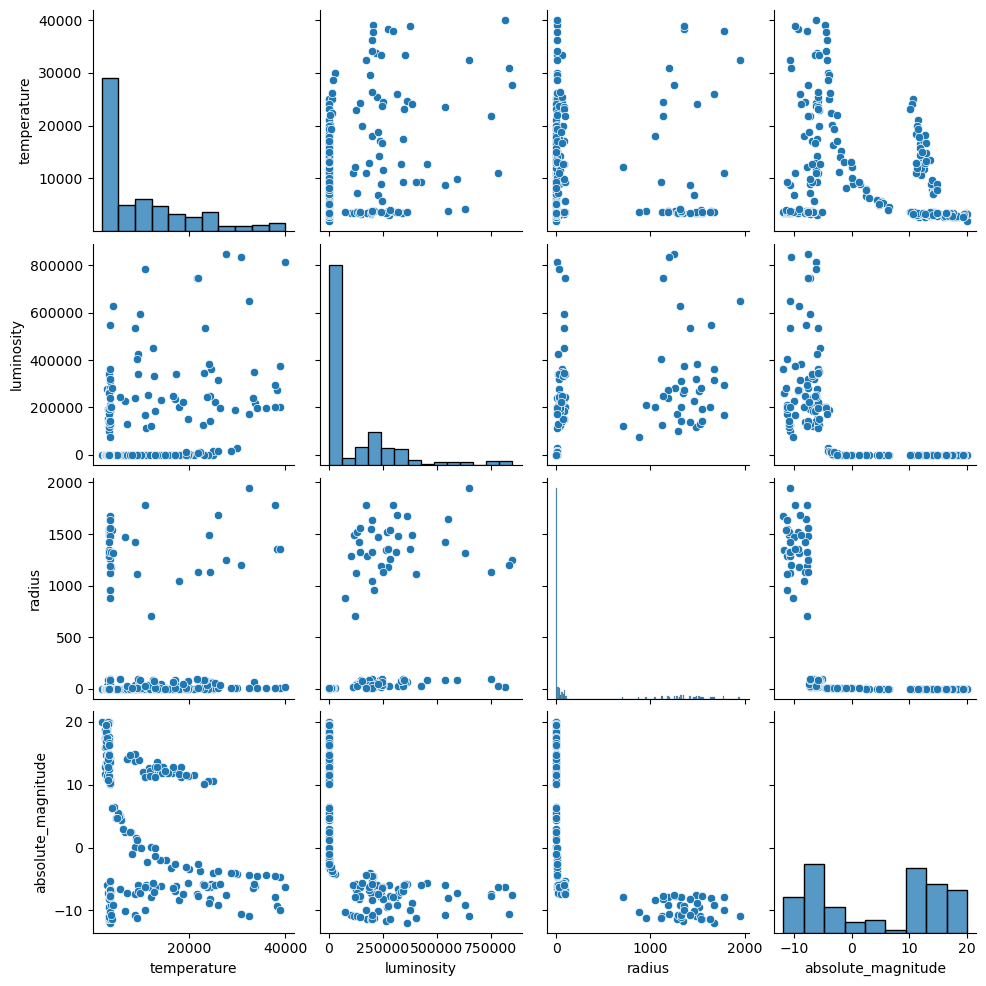

In [3]:
sns.pairplot(data)
plt.show()

In [4]:
def create_contingency_table(dataset, column1, column2):
    return dataset.groupby([column1, column2]).size().unstack(column1, fill_value=0)

#### Star type by radius, luminosity and absolute magnitude

In [5]:
len(data.star_type.value_counts())

6

Ik verwacht 6 clusters te zien voor radius, en mogelijk luminosity en absolute magnitude, parallel aan de 6 verschillende star types. 

In [6]:
properties_star_types = ['radius','luminosity', 'absolute_magnitude']
km_star_types = KMeans(n_clusters=6, random_state=43).fit(data[properties_star_types])

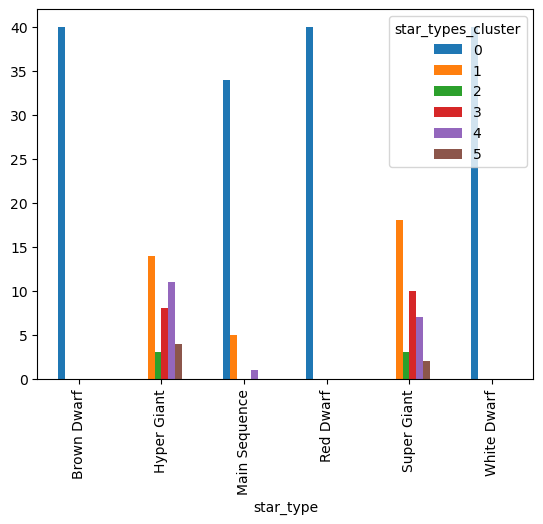

In [7]:
data['star_types_cluster'] = km_star_types.predict(data[properties_star_types])
cluster_vs_type = create_contingency_table(data, 'star_types_cluster', 'star_type')
cluster_vs_type.plot(kind='bar')
plt.show()

Het lijkt erop dat het algoritme niet gemakkelijk de verschillende type dwergen uit elkaar kan houden. Als we kijken naar de verdeling van radii in de volgende grafiek, kunnen we zien dat de hyper giants erg ver boven alles uitsteken, wat het misschien moeilijk maakt voor het algoritme om hier een scheiding te maken.

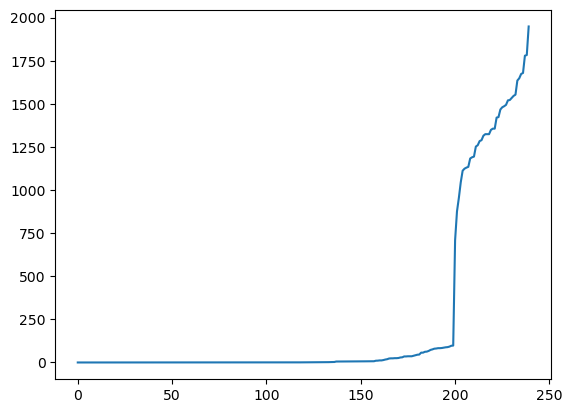

In [8]:
data['radius'].sort_values(ignore_index=True).plot()
plt.show()

We kunnen wel kijken of het beter werkt als we de giants eruit filteren.

In [9]:
small_radii = data.loc[data['radius'] < 12].copy()
km_star_types_small_radii = KMeans(n_clusters=4, random_state=43).fit(small_radii[properties_star_types])

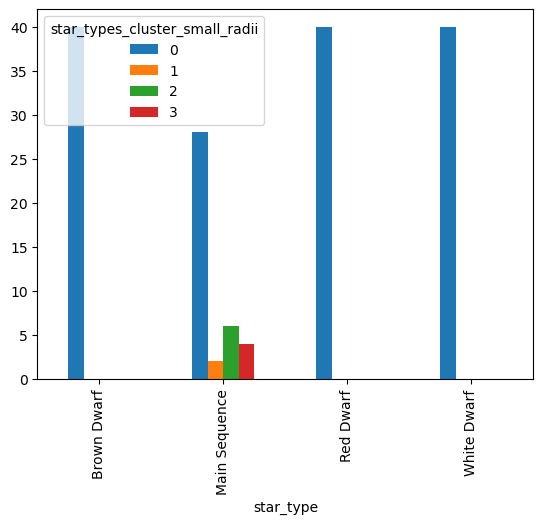

In [10]:
small_radii['star_types_cluster_small_radii'] = km_star_types_small_radii.predict(small_radii[properties_star_types])
cluster_vs_type_small_radii = create_contingency_table(small_radii, 'star_types_cluster_small_radii', 'star_type')
cluster_vs_type_small_radii.plot(kind='bar')
plt.show()

Of misschien alleen de dwergen.

In [11]:
small_radii_dwarfs = data.loc[data['radius'] < 0.75].copy()
km_star_types_small_radii_dwarfs = KMeans(n_clusters=3, random_state=43).fit(small_radii_dwarfs[properties_star_types])

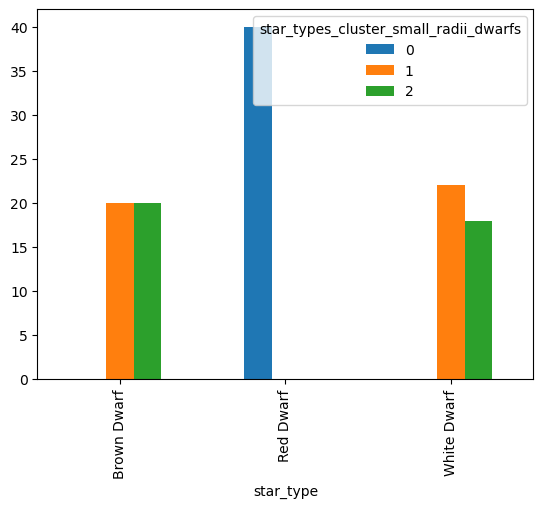

In [12]:
small_radii_dwarfs['star_types_cluster_small_radii_dwarfs'] = km_star_types_small_radii_dwarfs.predict(small_radii_dwarfs[properties_star_types])
type_vs_cluster_dwarfs = create_contingency_table(small_radii_dwarfs, 'star_types_cluster_small_radii_dwarfs', 'star_type')
type_vs_cluster_dwarfs.plot(kind='bar')
plt.show()

Naast rode dwergen kan er nog steeds niet een heel goed onderscheid gemaakt worden. Na wat uitproberen bleek dat absolulte magnitude een veel betere verdeling geeft. Dit komt waarschijnlijk omdat de verschillen veel minder verspreid zijn voor de absolute magnitude van sterren. Vervolgens een logaritme toevoegen van de radius (om de waarden meer gelijk te spreiden) geeft nog een betere verdeling, maar het logaritme toevoegen van de luminosity geeft weer een slechtere verdeling. Vooral de scheiding tussen main sequence en super giants is moeilijk te maken voor het algoritme. 

In [13]:
import numpy as np

In [14]:
data['log_radius'] = np.log(data['radius'])
data['l_to_m'] = np.log10(data['luminosity'])
properties_star_types_am = ['absolute_magnitude', 'log_radius']
km_star_types_am = KMeans(n_clusters=6, random_state=43).fit(data[properties_star_types_am])

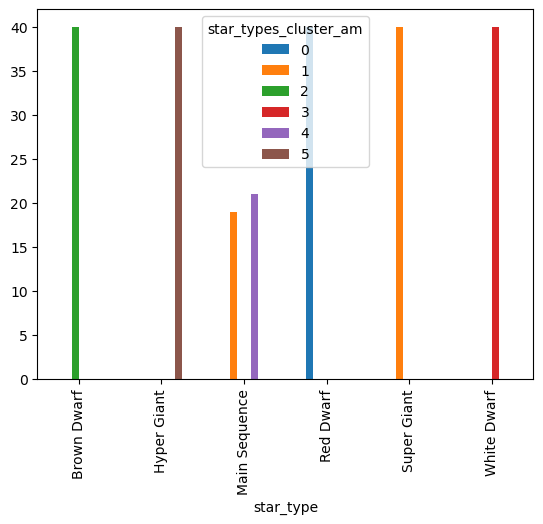

In [15]:
data['star_types_cluster_am'] = km_star_types_am.predict(data[properties_star_types_am])
cluster_vs_type_am = create_contingency_table(data, 'star_types_cluster_am', 'star_type')
cluster_vs_type_am.plot(kind='bar')
plt.show()

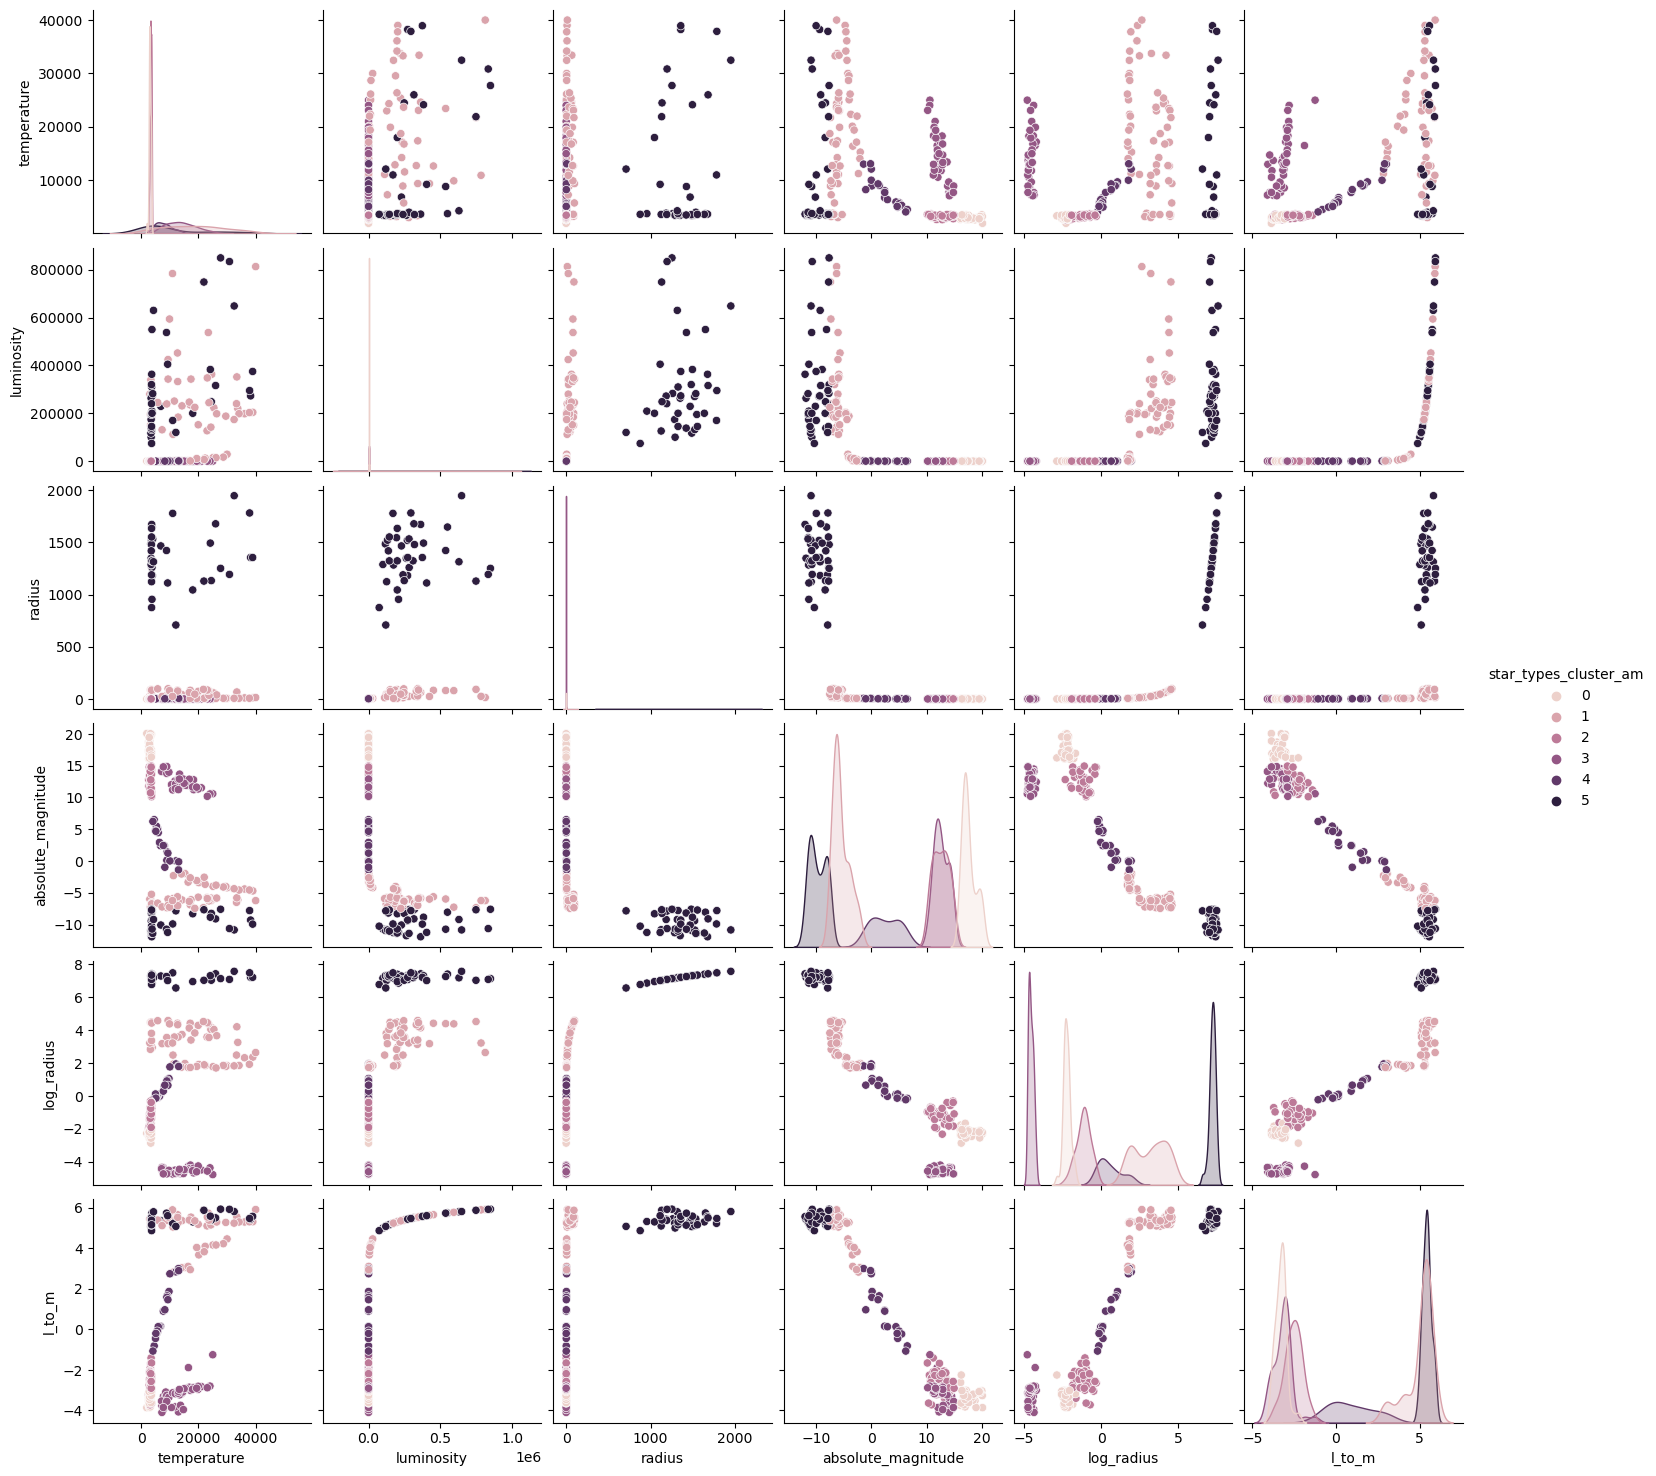

In [16]:
sns.pairplot(data.drop(['star_types_cluster'], axis=1), hue="star_types_cluster_am")
plt.show()

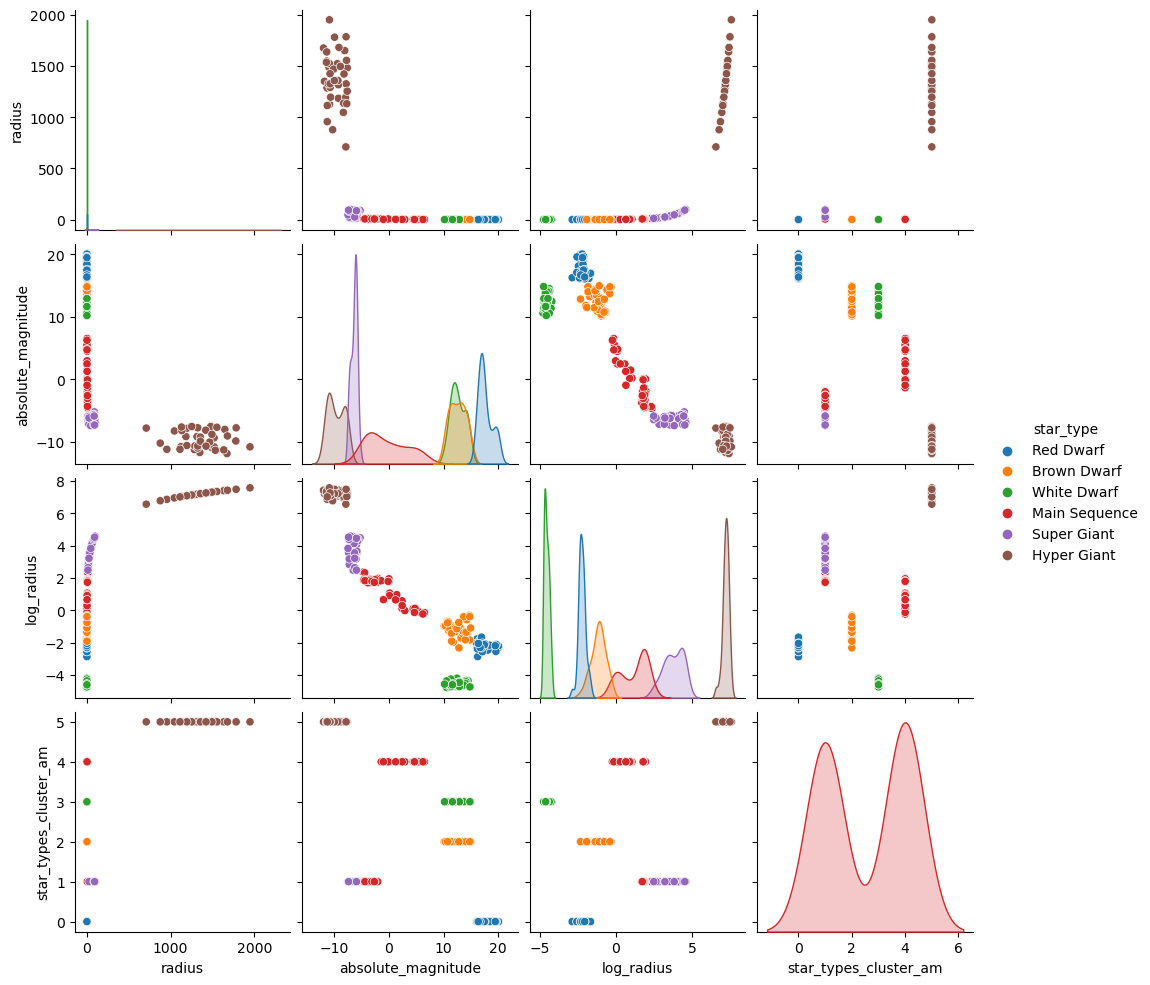

In [17]:
sns.pairplot(data.drop([ 'star_types_cluster', 'luminosity', 'l_to_m', 'temperature'], axis=1), hue="star_type")
plt.show()

In [18]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [19]:
print('Silhouette score voor absolute_magnitude, radius en luminosity: ' + str(metrics.silhouette_score(data[properties_star_types], km_star_types.labels_, metric='euclidean')))
print('Silhouette score voor absolute_magnitude en log_radius: ' + str(metrics.silhouette_score(data[properties_star_types_am], km_star_types_am.labels_, metric='euclidean')))

Silhouette score voor absolute_magnitude, radius en luminosity: 0.8457863769043892
Silhouette score voor absolute_magnitude en log_radius: 0.6115536255943376


De silhouette score is lager, maar dit is niet heel raar omdat de score waarschijnlijk is gebaseerd op hoeveel afstand er tussen de clusters is, en bij de eerste is de verdeling een stuk verder van elkaar omdat de getallen voor radius en luminosity verder uit elkaar liggen.

Het KMeans algoritme lijkt dus niet ideaal voor data sets waar de data niet lineair schaalt. Dit is logisch, omdat er telkens wordt gekeken naar het gemiddelde van een cluster en hiermee het center van de cluster verplaatst.